# <div align='center'> Ковариация и корреляция </div>

<div align='center'> <b><big> Преподаватель: Маргарян Ашот Араратович </big> </b> </div>

<div align='center'> <b><i> Центральный университет, Москва </i> </b> </div>

<div align='center'> <i> Открытый урок, 04 июля 2025 г. </i> </div>

## Материалы занятия

Материалы этого занятия доступны по следующему QR-коду

<a href="http://qrcoder.ru" target="_blank"><img src="http://qrcoder.ru/code/?https%3A%2F%2Fgithub.com%2Fmarashot96%2FLections%2Fblob%2Fmain%2FCorrel%2FNavigator.md&8&0" width="360" height="360" border="0" title="QR код"></a>

## План занятия

- Определение **ковариации** двух случайных величин из формулы дисперсии суммы двух случайных величин
- Линейная **корреляция Пирсона**; ранговая **корреляция Спирмена**;
- $t$-критерий для проверки значимости линейная корреляция Пирсона;
- **Практическая задача 1.** Определение **корректных метрик** на примере данных о посещении онлайн-кинотеатра;
- **корреляция Мэтьюнса;** $\chi^2$-критерий проверки;
- **Практическая задача 2.** Определение зависимости между **двумя бинарными показателями** на примере зависимости лояльных и активных клиентов онлайн-магазина;
- Таблица сопряженности, **Корреляция Крамера**;
- **Практическая задача 3.** Категорийная зависимость на примере жанров тайтлов.


In [ ]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import t, chi2, ttest_ind, pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

## Задача 1. Кинотеатр

Скачайте и импортируйте файл *CentralCinema_signups*.

**Описание данных**

 - *id_client* - уникальный идентификатор клиента.
 - *date_come* - дата первой подписки (на первый месяц).
 - *flag_X* - флаг (факт) продления на Х дней после первого месяца.
 - *COST* - суммарные косты на привлечение (и обслуживание) данного клиента.


In [ ]:
df = pd.read_excel('https://drive.google.com/uc?export=download&id=1cjnwRtE-1XmmLPjasFit3YII8RDT8sGj')
df['date_come'] = pd.to_datetime(df['date_come'], format='%d.%m.%Y')
df.head(3)

,id_client,date_come,flag_30,flag_60,flag_90,flag_120,flag_150,flag_180,COST
0,102308,2021-02-24,0,0,0,0,0,0,85
1,100139,2020-11-29,1,1,1,0,0,0,50
2,100300,2021-02-09,1,1,1,0,0,0,85


Добавим после *cohort* как месяц "продуктового рождения", а также поле *lifetime* как сумму всех флагов плюс 1.

In [ ]:
df['cohort'] = df['date_come'].dt.to_period('M').dt.to_timestamp()
df['lifetime'] = df['flag_30'] + df['flag_60'] + df['flag_90'] + df['flag_120'] + df['flag_150'] + df['flag_180'] + 1
df.head(3)

,id_client,date_come,flag_30,flag_60,flag_90,flag_120,flag_150,flag_180,COST,cohort,lifetime
0,102308,2021-02-24,0,0,0,0,0,0,85,2021-02-01,1
1,100139,2020-11-29,1,1,1,0,0,0,50,2020-11-01,4
2,100300,2021-02-09,1,1,1,0,0,0,85,2021-02-01,4


### 1.1 Квантильный анализ клиентских просмотров

Скачайте файл *Watch_clients.csv*, переведите длину каждого просмотра в минуты и проведите квантильный анализ для очистки выбросов.

Найдите для каждого клиента суммарное время и количество просмотров и соедините эту информацию с таблицей регистраций.

In [ ]:
dfw = pd.read_excel("https://drive.google.com/uc?export=download&id=1w3Ue1JKJq8l_qBZTkSYhi-z2ENBNiCYk")

dfw.head()

,id_client,start_watch,end_watch
0,100219,2021-08-01 10:50:00,2021-08-01 12:52:00
1,100660,2021-01-11 06:58:00,2021-01-11 08:03:00
2,101971,2021-05-25 02:41:00,2021-05-25 02:44:00
3,100371,2020-11-25 14:48:00,2020-11-25 14:50:00
4,102386,2021-03-09 14:17:00,2021-03-09 15:21:00


In [ ]:
dfw['start_watch'] = pd.to_datetime(dfw['start_watch'], format='%d.%m.%Y %H:%M')
dfw['end_watch'] = pd.to_datetime(dfw['end_watch'], format='%d.%m.%Y %H:%M')

dfw['len'] = dfw['end_watch'] - dfw['start_watch']
dfw['len_watch_all_min'] = dfw['len'].dt.components['days']*60*24 + dfw['len'].dt.components['hours']*60+ dfw['len'].dt.components['minutes']

dfw.head()

,id_client,start_watch,end_watch,len,len_watch_all_min
0,100219,2021-08-01 10:50:00,2021-08-01 12:52:00,0 days 02:02:00,122
1,100660,2021-01-11 06:58:00,2021-01-11 08:03:00,0 days 01:05:00,65
2,101971,2021-05-25 02:41:00,2021-05-25 02:44:00,0 days 00:03:00,3
3,100371,2020-11-25 14:48:00,2020-11-25 14:50:00,0 days 00:02:00,2
4,102386,2021-03-09 14:17:00,2021-03-09 15:21:00,0 days 01:04:00,64


In [ ]:
dfw.sort_values('len_watch_all_min', ascending = False).head(3)

,id_client,start_watch,end_watch,len,len_watch_all_min
8201,100932,2021-07-26 23:25:00,2021-07-29 02:25:00,2 days 03:00:00,3060
5179,101448,2021-02-22 18:38:00,2021-02-24 21:35:00,2 days 02:57:00,3057
27780,100693,2020-11-30 04:50:00,2020-12-02 07:44:00,2 days 02:54:00,3054


Проведём **квантильный анализ**.

Для этого посмотрим все квантильные значения, начиная с $0.9$ с шагом по $0.01$.

In [ ]:
for i in range (1,9):
  q = np.quantile(dfw['len_watch_all_min'], .9 + i*.01)
  print(q)

125.0
125.0
125.0
125.0
125.0
126.0
1209.280000000006
1829.5199999999895


Выберем границу в районе $300$, чтобы отсечь $2\%$ самых крупных значений.

In [ ]:
dfw_s = dfw[dfw['len_watch_all_min'] <= 300]

### 1.2. Альтернативные методы обработки выбросов

Как еще можно обработать выбросы?

Одним из вариантов является использование графика boxplot, который еще часто называют "ящик с усами". Данную диаграмму часто используют для быстрой оценки данных. Она также как и гистограмма показывает распределение значений в выборке.
Основное преимущество диаграммы боксплот в том, что она компактно и наглядно показывает основные статистические показатели:
- Медиану (50% квартиль) - это линия по середине прямоугольника
- Верхний и нижний квартили (25% и 75%) - верхняя и нижняя граница прямоугольника
- Наблюдаемые минимумы и максимумы
- А также выбросы в данных, в виде отдельных точек

Пример боксплота можно посмотреть на картинке ниже.
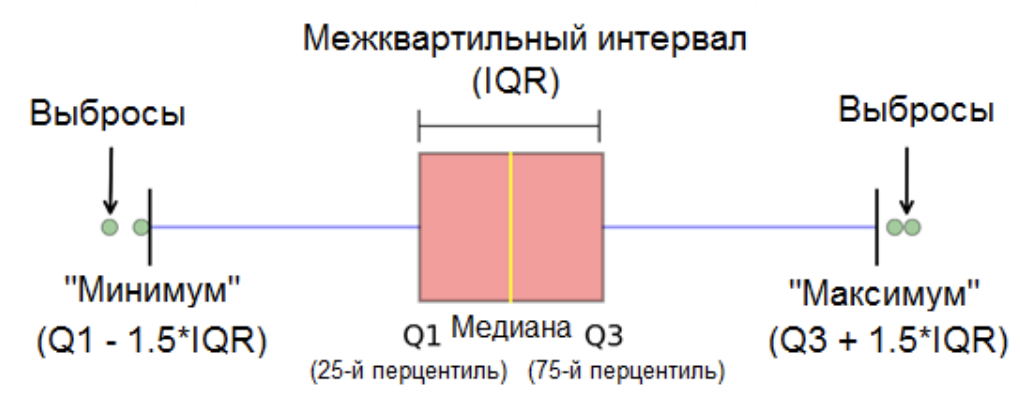

Так как же при помощи боксплота обрабатывать выбросы? Сказать, что работать с выбросами мы будем, используя боксплот - не совсем верно. Данная диаграмма лишь подтверждает нам наличие выбросов, а также подсвечивает все необходимые величины для расчета диапазона, за пределами которого останутся выбросы.

Определить диапазон без выбросов можно следующим образом



$
\large (Q_1 - 1.5IQR, Q_3 + 1.5IQR)
$

, где $Q_1$ - 25ый перцентиль, $Q_3$ - 75ый перцентиль, $IQR = Q_3 - Q_1$






Построим боксплот для исходного распределения нашей метрики

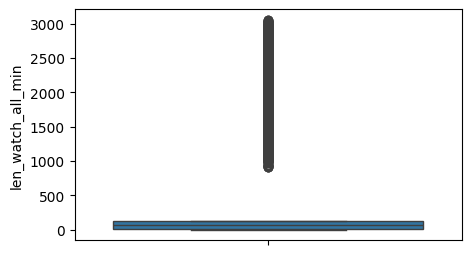

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
sns.boxplot(dfw['len_watch_all_min'])
plt.show()

In [ ]:
iqr = np.quantile(dfw['len_watch_all_min'], 0.75) - np.quantile(dfw['len_watch_all_min'], 0.25)
q1 = np.quantile(dfw['len_watch_all_min'], 0.25)
q3 = np.quantile(dfw['len_watch_all_min'], 0.75)
dfw_3 = dfw[((dfw['len_watch_all_min'] <= q3 + 1.5*iqr) & (dfw['len_watch_all_min'] >= q1 - 1.5*iqr))]

После работы с выбросами:

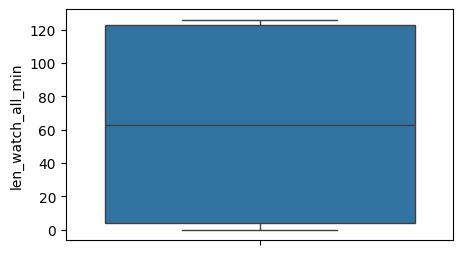

In [ ]:
sns.boxplot(dfw_3['len_watch_all_min'])
plt.show()

### 1.3 Линейная корреляция Пирсона

В качестве метрики смотрения возьмём **суммарную длительность смотрения за весь период жизни**.

Рассчитаем коэффициент линейной корреляции Пирсона между показателем клиентского лайфтайма и суммарным временем клиентских просмотров.

$\large \rho_{X,Y} = \frac{\text{cov}(X, Y)}{\sqrt{Var(X)} \cdot \sqrt{Var(Y)}} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}}$




In [ ]:
dfw_gr = dfw.groupby('id_client').agg(sum_len = ('len_watch_all_min','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')

len_m = df_fin['sum_len'].mean()
lt_m  = df_fin['lifetime'].mean()

print("Среднее время посмотра = ", len_m)
print("Средний клиентский лайфтайм = ", lt_m)

Среднее время посмотра =  1768.2918334667734
Средний клиентский лайфтайм =  2.9947958366693355


Переёдм к ковариационной матрице и рассчитаем линейную корреляцию с её помощью.

In [ ]:
matr_cov = np.cov(df_fin['sum_len'], df_fin['lifetime'])
print(matr_cov)
print()
print("Сумма элементов ковариационной матрицы = ", matr_cov.sum())

[[3.28386450e+06 1.46898430e+03]
 [1.46898430e+03 2.60670098e+00]]

Сумма элементов ковариационной матрицы =  3286805.0719957626


Рассчитаем коэффициент линейной корреляции Пирсона

In [ ]:
corr_pears = (matr_cov[0][1]/(matr_cov[0][0]*matr_cov[1][1])**.5).item()

print("Корреляция = ", corr_pears)

Корреляция =  0.5020869483080622


In [ ]:
s, p = pearsonr(df_fin['sum_len'], df_fin['lifetime'])

print(s)
print(p)

0.5020869483080618
1.161482525784239e-159


### 1.4 Зависимость метрик в онлайн-кинотеатре

Теперь рассмотрим различные варианты в качестве "метрики смотрения".

Как именно зависит корреляция от типа метрики и выбросов?

#### Метрика 1. Суммарное смотрение

Корреляция ***суммарного кол-ва минут смотрения за период клиентской жизни*** и лайфтайма

**Рассмотрим выборку с выбросами**

In [ ]:
dfw_gr = dfw.groupby('id_client').agg(sum_len = ('len_watch_all_min','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')

s, p = pearsonr(df_fin['sum_len'], df_fin['lifetime'])
print("Корреляция Пирсона лайфтайма и суммарного времени просмотра = ", s)
print("P_value = ", p)

print()

s, p = spearmanr(df_fin['sum_len'], df_fin['lifetime'])
print("Корреляция Спирмена лайфтайма и суммарного времени просмотра = ", s)
print("P_value = ", p)

Корреляция Пирсона лайфтайма и суммарного времени просмотра =  0.5020869483080618
P_value =  1.161482525784239e-159

Корреляция Спирмена лайфтайма и суммарного времени просмотра =  0.6340506414682912
P_value =  5.077461253908477e-281


**Рассмотрим выборку без выбросов**

In [ ]:
dfw_gr = dfw_s.groupby('id_client').agg(sum_len = ('len_watch_all_min','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')

s, p = pearsonr(df_fin['sum_len'], df_fin['lifetime'])
print("Корреляция Пирсона лайфтайма и суммарного времени просмотра = ", s)
print("P_value = ", p)

print()

s, p = spearmanr(df_fin['sum_len'], df_fin['lifetime'])
print("Корреляция Спирмена лайфтайма и суммарного времени просмотра = ", s)
print("P_value = ", p)

Корреляция Пирсона лайфтайма и суммарного времени просмотра =  0.71347112751228
P_value =  0.0

Корреляция Спирмена лайфтайма и суммарного времени просмотра =  0.7885292077625486
P_value =  0.0


Данная метрика обладает *натуральной корреляцией* с лайфтаймом, так как при прочих равных "чем больше живёшь, тем больше накопленно смотришь".

**Данная метрика не подходит.**

#### Метрика 2. Среднемесячное смотрение

Корреляция ***среднего кол-ва минут смотрения за один месяц клиентской жизни*** и лайфтайма

**Рассмотрим выборку с выбросами**

In [ ]:
dfw_gr = dfw.groupby('id_client').agg(sum_len = ('len_watch_all_min','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')
df_fin['avg_watch'] = df_fin['sum_len'] / df_fin['lifetime']

s, p = pearsonr(df_fin['avg_watch'], df_fin['lifetime'])
print("Корреляция Пирсона лайфтайма и среднемесячного времени просмотра = ", s)
print("P_value = ", p)

print()

s, p = spearmanr(df_fin['avg_watch'], df_fin['lifetime'])
print("Корреляция Спирмена лайфтайма и среднемесячного времени просмотра = ", s)
print("P_value = ", p)

Корреляция Пирсона лайфтайма и среднемесячного времени просмотра =  0.012488783410895939
P_value =  0.5326924342416968

Корреляция Спирмена лайфтайма и среднемесячного времени просмотра =  0.21392368486850727
P_value =  3.0218343524498217e-27


**Рассмотрим выборку без выбросов**

In [ ]:
dfw_gr = dfw_s.groupby('id_client').agg(sum_len = ('len_watch_all_min','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')
df_fin['avg_watch'] = df_fin['sum_len'] / df_fin['lifetime']

s, p = pearsonr(df_fin['avg_watch'], df_fin['lifetime'])
print("Корреляция Пирсона лайфтайма и среднемесячного времени просмотра = ", s)
print("P_value = ", p)

print()

s, p = spearmanr(df_fin['avg_watch'], df_fin['lifetime'])
print("Корреляция Спирмена лайфтайма и среднемесячного времени просмотра = ", s)
print("P_value = ", p)

Корреляция Пирсона лайфтайма и среднемесячного времени просмотра =  0.09851268784409033
P_value =  8.171534908642782e-07

Корреляция Спирмена лайфтайма и среднемесячного времени просмотра =  0.1452900677217466
P_value =  3.013640813938438e-13


**Данная метрика не подходит**, так как с течением месяцев клиентской жизни интенсивность смотрения снижается.

#### Метрика 3. Смотрение в первый месяц

Корреляция ***суммарного кол-ва минут смотрения в первый месяц подписки*** и лайфтайма

**Рассмотрим выборку с выбросами**

In [ ]:
dfw_f = dfw.merge(df, on ='id_client')
dfw_f['1_month'] = np.where((dfw_f['start_watch'] - dfw_f['date_come']) > datetime.timedelta(days=30),0,1)


dfw_gr = dfw_f[dfw_f['1_month']==1].groupby('id_client').agg(sum_len = ('len','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')
df_fin['len_watch_all_min'] = df_fin['sum_len'].dt.components['days']*60*24 + df_fin['sum_len'].dt.components['hours']*60+ df_fin['sum_len'].dt.components['minutes']

s, p = pearsonr(df_fin['len_watch_all_min'], df_fin['lifetime'])
print("Корреляция Пирсона лайфтайма и суммарного времени просмотра в первый месяц = ", s)
print("P_value = ", p)
print()

s, p = spearmanr(df_fin['len_watch_all_min'], df_fin['lifetime'])
print("Корреляция Спирмена лайфтайма и суммарного времени просмотра в первый месяц = ", s)
print("P_value = ", p)

Корреляция Пирсона лайфтайма и суммарного времени просмотра в первый месяц =  0.22920426587984233
P_value =  3.8998282439725993e-31

Корреляция Спирмена лайфтайма и суммарного времени просмотра в первый месяц =  0.4548387563620661
P_value =  8.334270816711225e-128


**Рассмотрим выборку без выбросов**

In [ ]:
dfw_f = dfw_s.merge(df, on ='id_client')
dfw_f['1_month'] = np.where((dfw_f['start_watch'] - dfw_f['date_come']) > datetime.timedelta(days=30),0,1)


dfw_gr = dfw_f[dfw_f['1_month']==1].groupby('id_client').agg(sum_len = ('len','sum'), cnt_watch = ('id_client','count')).reset_index()
df_fin = dfw_gr.merge(df, on = 'id_client')
df_fin['len_watch_all_min'] = df_fin['sum_len'].dt.components['days']*60*24 + df_fin['sum_len'].dt.components['hours']*60+ df_fin['sum_len'].dt.components['minutes']

s, p = pearsonr(df_fin['len_watch_all_min'], df_fin['lifetime'])
print("Корреляция Пирсона лайфтайма и среднего времени просмотра в месяц = ", s)
print("P_value = ", p)
print()

s, p = spearmanr(df_fin['len_watch_all_min'], df_fin['lifetime'])
print("Корреляция Спирмена лайфтайма и среднего времени просмотра в месяц = ", s)
print("P_value = ", p)

Корреляция Пирсона лайфтайма и среднего времени просмотра в месяц =  0.511432638012755
P_value =  2.586128196613173e-166

Корреляция Спирмена лайфтайма и среднего времени просмотра в месяц =  0.5707729730879625
P_value =  1.3558070000570688e-215


## Задача 2. Ритейлер


### 2.1. Exploratory Data Analysis

Ты работаешь аналитиком в онлайн-ритейлере, и твоя задача — найти закономерности в клиентском поведении.

Введём два определения:
  1. *Лояльный клиент* — тот, кто участвует в *программе лояльности*, то есть приобрел карту лояльности и получает баллы за покупки.
  2. *Активный клиент* — тот, кто покупает «много и часто».

Необходимо каждому клиенту из файла *Online_Shop.xlsx* проставить флаг лояльности (основанный на листе 'loy') и флаг активности, определение которого тебе нужно разработать самостоятельно (основываясь на истории клиентских платежей).

С помощью коэффициента корреляции Мэтьюса определи, есть ли статистическая зависимость между клиентскими *лояльностью* и *активностью*.

In [3]:
df_loy = pd.read_excel('https://drive.google.com/uc?export=download&id=1hcD6wVieg-fpEsLOwfi1418sryYL7x6Q', sheet_name='loy')
df_pay = pd.read_excel('https://drive.google.com/uc?export=download&id=1hcD6wVieg-fpEsLOwfi1418sryYL7x6Q', sheet_name='payment')

df_pay['date_pay'] = pd.to_datetime(df_pay['date_pay'])
df_loy['date_loy'] = pd.to_datetime(df_loy['date_loy'])

df_loy['month_loy'] = df_loy['date_loy'].dt.to_period('M').dt.to_timestamp()
df_pay['month_pay'] = df_pay['date_pay'].dt.to_period('M').dt.to_timestamp()

In [4]:
df_pay.head(3)

,id_client,date_pay,amt_pay,month_pay
0,204035,2023-09-12 06:55:33.669,10743.0,2023-09-01
1,100476,2023-08-02 19:56:43.888,4473.0,2023-08-01
2,201952,2021-10-21 08:07:43.236,8073.0,2021-10-01


In [5]:
df_loy.head(3)

,id_client,date_loy,month_loy
0,100301,2023-10-13,2023-10-01
1,100302,2023-07-20,2023-07-01
2,100303,2023-12-05,2023-12-01


Визуализируем распределение количества оформлений лояльности по месяцам.

Для этого сначала построим необходимые сводные таблицы.

In [7]:
df_loy_month_gr = df_loy.groupby('month_loy').agg(cnt = ('id_client','count')).reset_index()
df_pay_month_gr = df_pay.groupby('month_pay').agg(cnt = ('id_client','count')).reset_index()

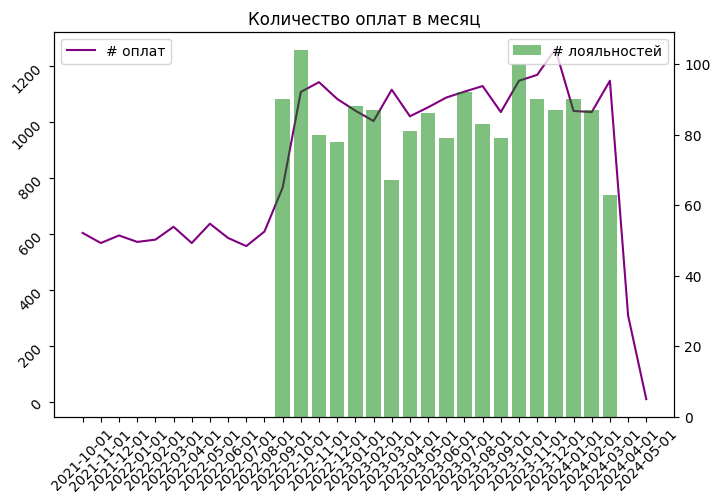

In [8]:
plt.rcParams["figure.figsize"] = (8,5)
fig, ax = plt.subplots()
ax.plot(df_pay_month_gr['month_pay'].astype(str), df_pay_month_gr['cnt'], color = 'purple', label = '# оплат')
ax2 = ax.twinx()
ax2.bar(df_loy_month_gr['month_loy'].astype(str), df_loy_month_gr['cnt'], color = 'green', alpha = .5, label = '# лояльностей')
ax.tick_params(rotation = 45)
plt.title("Количество оплат в месяц")
ax.legend()
ax2.legend()
plt.show()

Соединим информацию из двух таблиц и добавим *время клиентской жизни пользователя*.

In [9]:
our_today = df_pay['date_pay'].max()
print(our_today)

df_pay_gr = df_pay.groupby('id_client').agg(min_date = ('date_pay','min'), cnt = ('id_client','count'), sum_pay = ('amt_pay','sum')).reset_index()
df_pay_gr['months'] = round((our_today - df_pay_gr['min_date']).dt.days/30,0)

df_fin = df_pay_gr.merge(df_loy, on = 'id_client', how = 'left')
df_fin['flag_loy'] = np.where(df_fin['date_loy'].isnull(),0,1)
df_fin.head(3)

2024-05-07 20:42:37.375000


,id_client,min_date,cnt,sum_pay,months,date_loy,month_loy,flag_loy
0,100301,2023-10-20 17:04:40.301,4,21332.000000,7.0,2023-10-13,2023-10-01,1
1,100302,2023-07-24 01:21:43.606,8,46827.000000,10.0,2023-07-20,2023-07-01,1
2,100303,2023-12-06 02:51:18.788,8,38789.234237,5.0,2023-12-05,2023-12-01,1


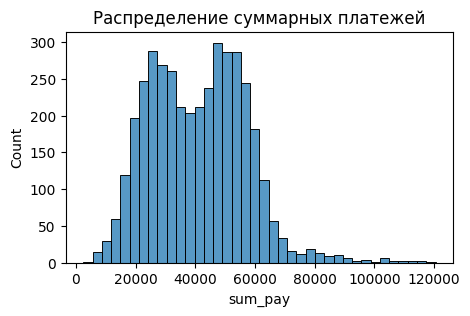

In [10]:
plt.rcParams["figure.figsize"] = (5,3)
sns.histplot(df_fin['sum_pay'])
plt.title("Распределение суммарных платежей")
plt.show()

Проведём квантильный анализ верхних $30\%$ пользователей.

In [15]:
for i in range(0,30):
  print(f"квантилю {round(.7+i*.01,2)} соответсвует {round(np.quantile(df_fin['sum_pay'], .7+i*.01),2) }")

квантилю 0.7 соответсвует 50486.0
квантилю 0.71 соответсвует 50965.02
квантилю 0.72 соответсвует 51318.92
квантилю 0.73 соответсвует 51794.01
квантилю 0.74 соответсвует 52102.32
квантилю 0.75 соответсвует 52649.5
квантилю 0.76 соответсвует 52991.84
квантилю 0.77 соответсвует 53493.32
квантилю 0.78 соответсвует 53953.66
квантилю 0.79 соответсвует 54334.22
квантилю 0.8 соответсвует 54776.05
квантилю 0.81 соответсвует 55116.16
квантилю 0.82 соответсвует 55553.28
квантилю 0.83 соответсвует 56030.94
квантилю 0.84 соответсвует 56516.48
квантилю 0.85 соответсвует 56977.5
квантилю 0.86 соответсвует 57575.7
квантилю 0.87 соответсвует 58089.28
квантилю 0.88 соответсвует 58664.8
квантилю 0.89 соответсвует 59213.04
квантилю 0.9 соответсвует 59838.94
квантилю 0.91 соответсвует 60505.35
квантилю 0.92 соответсвует 61306.92
квантилю 0.93 соответсвует 62278.5
квантилю 0.94 соответсвует 63343.58
квантилю 0.95 соответсвует 64640.7
квантилю 0.96 соответсвует 67045.57
квантилю 0.97 соответсвует 69375.46
кв

### 2.2. Как определить метрику активности?


#### Метрика 1. Суммарные траты

Допустим, что активные пользователи — это топ-$30\%$ процентов пользователей, которые суммарно за время жизни (**LT**) оставили в онлайн-ритейлере больше всего денег.

In [16]:
df_fin['flag_active'] = np.where(df_fin['sum_pay'] <= 50000,0,1)
df_fin.head(3)

,id_client,min_date,cnt,sum_pay,months,date_loy,month_loy,flag_loy,flag_active
0,100301,2023-10-20 17:04:40.301,4,21332.000000,7.0,2023-10-13,2023-10-01,1,0
1,100302,2023-07-24 01:21:43.606,8,46827.000000,10.0,2023-07-20,2023-07-01,1,0
2,100303,2023-12-06 02:51:18.788,8,38789.234237,5.0,2023-12-05,2023-12-01,1,0


**Корреляция Мэтьюса:**

\\

$
\large MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP) \cdot (TP + FN) \cdot (TN + FP) \cdot (TN + FN)}}
$

In [ ]:
a = len(df_fin[(df_fin['flag_loy']==1) & (df_fin['flag_active']==1)])
b = len(df_fin[(df_fin['flag_loy']==0) & (df_fin['flag_active']==1)])
c = len(df_fin[(df_fin['flag_loy']==1) & (df_fin['flag_active']==0)])
d = len(df_fin[(df_fin['flag_loy']==0) & (df_fin['flag_active']==0)])

print(a)
print(b)
print(c)
print(d)
print()
print(len(df_fin))

n = a + b + c + d
print(n)

92
1135
1205
1528

3960
3960


In [ ]:
matthews_coeff = (a*d - b*c) / ((a + b) * (a + c) * (b + d) * (c + d))**.5

print(matthews_coeff)

-0.3605636435673008


In [ ]:
chi2_calc_val = n * (matthews_coeff**2)
print(chi2_calc_val)

514.824318607609


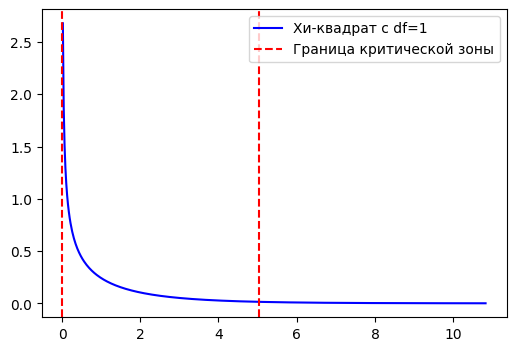

In [ ]:
q1 = chi2.ppf(.025, df = 1)
q2 = chi2.ppf(.975, df = 1)
x = np.linspace(0, chi2.ppf(0.999, 1), 500)

fig, ax = plt.subplots(1,1)
ax.plot(x, chi2.pdf(x, 1), color = 'blue', label = 'Хи-квадрат с df=1')
#ax.axvline(chi2_calc_val, color = 'purple', label = 'Расчётное значение')
ax.axvline(q1, color = 'red', linestyle = '--', label = 'Граница критической зоны')
ax.axvline(q2, color = 'red', linestyle = '--')
ax.legend()
plt.show()

Рассчитаем вручную *p_value*

In [ ]:
p_val = 1 - chi2.cdf(chi2_calc_val, df = 1)
print(p_val)

0.0


**Корреляция Мэтьюса значима и отрицательна**

#### Метрика 2. Средние траты

Допустим, что активные пользователи — это топ-10% процентов пользователей, которые в среднем за месяц жизни оставили в онлайн-кинотеатре больше всего денег.

In [17]:
df_fin['avg_pay'] = df_fin['sum_pay'] / df_fin['months']
df_fin['avg_pay'] = df_fin['sum_pay'] / df_fin['months']
df_fin.head(3)

,id_client,min_date,cnt,sum_pay,months,date_loy,month_loy,flag_loy,flag_active,avg_pay
0,100301,2023-10-20 17:04:40.301,4,21332.000000,7.0,2023-10-13,2023-10-01,1,0,3047.428571
1,100302,2023-07-24 01:21:43.606,8,46827.000000,10.0,2023-07-20,2023-07-01,1,0,4682.700000
2,100303,2023-12-06 02:51:18.788,8,38789.234237,5.0,2023-12-05,2023-12-01,1,0,7757.846847


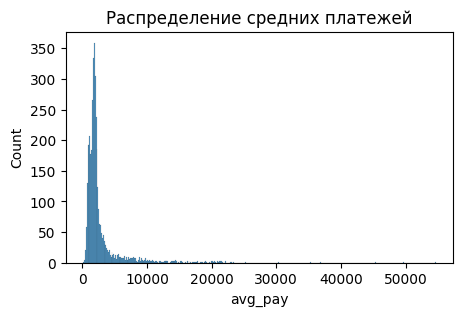

In [18]:
sns.histplot(df_fin['avg_pay'])
plt.title("Распределение средних платежей")
plt.show()

In [19]:
for i in range(0,30):
  print(round(.7 + i*.01,2), np.quantile(df_fin['avg_pay'], .7 + i*.01))

0.7 2256.7409340659337
0.71 2283.957525
0.72 2316.5414420062693
0.73 2362.7374675324677
0.74 2405.765857142857
0.75 2448.366477272727
0.76 2500.4385792793573
0.77 2572.021604278075
0.78 2635.789777777776
0.79 2727.621559139785
0.8 2804.595329005406
0.81 2906.8547619047617
0.82 3036.7950793650734
0.83 3172.683857142857
0.84 3282.3121367521367
0.85 3431.7883928571428
0.86 3632.2796666666645
0.87 3849.534318181818
0.88 4122.6457142857125
0.89 4489.859444444438
0.9 4869.434999999996
0.91 5431.614999999987
0.92 5937.059999999998
0.93 6603.258333333324
0.94 7385.680439980057
0.95 8184.127499999984
0.96 9307.631999999996
0.97 10872.482222222223
0.98 13900.25304993029
0.99 18855.429269010885


In [20]:
df_fin['flag_active'] = np.where(df_fin['avg_pay'] <= 2200,0,1)
df_fin.head(3)

,id_client,min_date,cnt,sum_pay,months,date_loy,month_loy,flag_loy,flag_active,avg_pay
0,100301,2023-10-20 17:04:40.301,4,21332.000000,7.0,2023-10-13,2023-10-01,1,1,3047.428571
1,100302,2023-07-24 01:21:43.606,8,46827.000000,10.0,2023-07-20,2023-07-01,1,1,4682.700000
2,100303,2023-12-06 02:51:18.788,8,38789.234237,5.0,2023-12-05,2023-12-01,1,1,7757.846847


**Корреляция Мэтьюса:**

\\

$
\large MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP) \cdot (TP + FN) \cdot (TN + FP) \cdot (TN + FN)}}
$

In [21]:
a = len(df_fin[(df_fin['flag_loy']==1) & (df_fin['flag_active']==1)])
b = len(df_fin[(df_fin['flag_loy']==0) & (df_fin['flag_active']==1)])
c = len(df_fin[(df_fin['flag_loy']==1) & (df_fin['flag_active']==0)])
d = len(df_fin[(df_fin['flag_loy']==0) & (df_fin['flag_active']==0)])

print(a)
print(b)
print(c)
print(d)
print()

n = a + b + c + d
print(n)

892
374
405
2289

3960


In [22]:
matthews_coeff = (a*d - b*c) / ((a + b) * (a + c) * (b + d) * (c + d))**.5

print(matthews_coeff)

0.5507615963000541


In [23]:
chi2_calc_val = n * (matthews_coeff**2)
print(chi2_calc_val)

p_val = 1 - chi2.cdf(chi2_calc_val, df = 1)
print(p_val)

1201.2198103975757
0.0


## Задача 3. Жанры тайтлов

Ты работаешь аналитиком в онлайн-ритейлере, и твоя задача — найти закономерности в контенте.

В файле *Titles_online_cinema.xlsx* хранится информация о *тайтлах* (фильмах, сериалах и прочих типах визуального контента).

Для каждого тайтла определены жанр, рейтинг и категория, которая автоматически устанавливается для каждого тайтла моделью искусственного интеллекта. Данная модель опирается на множество показателей тайтла и определяет для него одну из трёх категорий: Alpha, Beta, Gamma (от лучшего к худшему).

Твоя задача — определить, есть ли зависимость категории от жанра. Например, правда ли, что комедии — это в среднем более «низкокачественный» контент, чем триллеры или боевики?

Обрати внимание, что есть смысл также проверить корреляцию жанра и самого значения рейтинга на случай, если автокатегории по какой-то причине не подойдут.

In [4]:
dft = pd.read_excel('https://drive.google.com/uc?export=download&id=1oKjKemEQAQ80zlhjrphyrPleHaq_rjy9', sheet_name='title_list')
dft.head(3)

,id_title,genre,cat
0,300590,Триллер,Beta
1,300641,Детектив,Gamma
2,300914,Триллер,Gamma


In [6]:
matrix_o = pd.pivot_table(dft, index = 'genre', columns = 'cat', values = 'id_title', aggfunc = 'count', margins = True).reset_index()
matrix_o

cat,genre,Alpha,Beta,Gamma,All
0,Боевик,14,65,73,152
1,Детектив,22,100,88,210
2,Комедия,17,74,94,185
3,Мультфильм,39,114,108,261
4,Триллер,48,133,150,331
5,All,140,486,513,1139


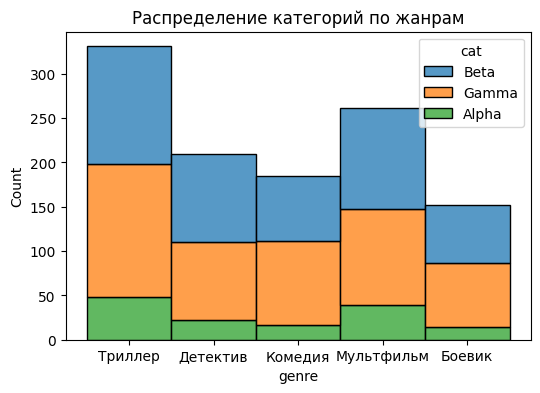

In [7]:
plt.rcParams["figure.figsize"] = (6,4)
sns.histplot(dft, x = 'genre', hue = 'cat', multiple="stack")
plt.title("Распределение категорий по жанрам")
plt.show()

Сохраним общее количество наблюдений в переменную

In [9]:
n_all = len(dft)
print(n_all)

1139


In [10]:
matrix_e = matrix_o.copy()

In [11]:
for i in dft['genre'].unique():
  for j in dft['cat'].unique():
    matrix_e.loc[matrix_e['genre']==i, j] = matrix_o[matrix_o['genre']==i]['All'].item() * matrix_o[matrix_o['genre']=='All'][j].item()/ n_all

matrix_e

/tmp/ipython-input-11-1165575234.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '141.2344161545215' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix_e.loc[matrix_e['genre']==i, j] = matrix_o[matrix_o['genre']==i]['All'].item() * matrix_o[matrix_o['genre']=='All'][j].item()/ n_all
/tmp/ipython-input-11-1165575234.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '149.08077260755047' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix_e.loc[matrix_e['genre']==i, j] = matrix_o[matrix_o['genre']==i]['All'].item() * matrix_o[matrix_o['genre']=='All'][j].item()/ n_all
/tmp/ipython-input-11-1165575234.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4

cat,genre,Alpha,Beta,Gamma,All
0,Боевик,18.683055,64.856892,68.460053,152
1,Детектив,25.812116,89.604917,94.582968,210
2,Комедия,22.739245,78.937665,83.323090,185
3,Мультфильм,32.080773,111.366111,117.553117,261
4,Триллер,40.684811,141.234416,149.080773,331
5,All,140.000000,486.000000,513.000000,1139


Для применения **хи-квадрат критерия согласия** необходимо

In [ ]:
chi2_stat = 0

for i in ['Боевик', 'Детектив', 'Комедия', 'Мультфильм', 'Триллер']:
  for j in ['Alpha', 'Beta', 'Gamma']:
    this_o = matrix_o[matrix_o['genre']==i][j].item()
    this_e = matrix_e[matrix_e['genre']==i][j].item()
    chi2_stat += (this_o - this_e)**2 / this_e

print(chi2_stat)

10.959903157111958


In [ ]:
K1 = dft['genre'].nunique()
K2 = dft['cat'].nunique()

degrfr = (K1 - 1) * (K2 - 1)

print(K1)
print(K2)
print(degrfr)

5
3
8


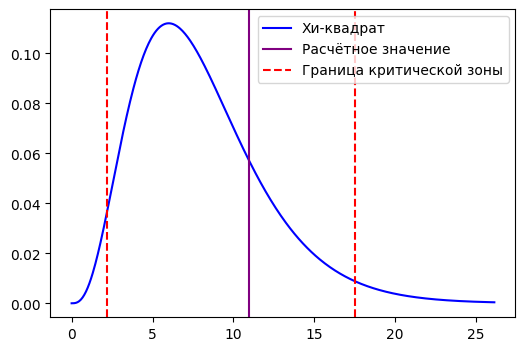

In [ ]:
q1 = chi2.ppf(.025, df = degrfr)
q2 = chi2.ppf(.975, df = degrfr)
x = np.linspace(0, chi2.ppf(0.999, degrfr), 500)

fig, ax = plt.subplots(1,1)
ax.plot(x, chi2.pdf(x, degrfr), color = 'blue', label = 'Хи-квадрат')
ax.axvline(chi2_stat, color = 'purple', label = 'Расчётное значение')
ax.axvline(q1, color = 'red', linestyle = '--', label = 'Граница критической зоны')
ax.axvline(q2, color = 'red', linestyle = '--')
ax.legend()
plt.show()

Перейдём от значения стат.критерия к **коэффициенту V-крамера**.

In [31]:
stat_value = chi2_stat/(n_all * (min(K1,K2)-1))**.5

print(stat_value)

2.230905661600638


**Вывод**

Статистически значимой зависимости между признаками нет (зависимость статистически не значима).



Выяснилось, однако, что при расстановке категорий для каждого тайтла использовалась модель машинного обучения, которая использовала жанр как одну из фичей кластеризации.

Возможно, если мы перейдём к "сырому" значению рейтинга, мы обнаружим корреляцию.

In [12]:
dfr = pd.read_excel('https://drive.google.com/uc?export=download&id=1oKjKemEQAQ80zlhjrphyrPleHaq_rjy9', sheet_name='raw_rating')
dfr['bin_rating'] = round(dfr['rating']*10,0)

dfr.head(3)

,id_title,rating,bin_rating
0,300590,0.64,6.0
1,300641,0.53,5.0
2,300914,0.46,5.0


In [13]:
dft_fin = dft.merge(dfr, on = 'id_title')
dft_fin.head(3)

,id_title,genre,cat,rating,bin_rating
0,300590,Триллер,Beta,0.64,6.0
1,300641,Детектив,Gamma,0.53,5.0
2,300914,Триллер,Gamma,0.46,5.0


Посмотрим распределение количества тайтлов по бинам рейтинга.

In [14]:
dft_fin.groupby('bin_rating').count()['id_title'].reset_index()

,bin_rating,id_title
0,3.0,1
1,4.0,60
2,5.0,181
3,6.0,440
4,7.0,296
5,8.0,148
6,9.0,13


Уберём бины рейтинга 3 и 9, так как там слишком мало наблюдений.

In [16]:
dft_fin = dft_fin[(dft_fin['bin_rating'] >= 4) & (dft_fin['bin_rating'] <= 8)]
dft_fin.groupby('bin_rating').count()['id_title'].reset_index()

,bin_rating,id_title
0,4.0,60
1,5.0,181
2,6.0,440
3,7.0,296
4,8.0,148


In [19]:
K1 = dft_fin['genre'].nunique()
K2 = dft_fin['bin_rating'].nunique()
degrfr = (K1 - 1) * (K2 - 1)

print(degrfr)

16


In [20]:
matrix_o = pd.pivot_table(dft_fin, index = 'genre', columns = 'bin_rating', values = 'id_title', aggfunc = 'count', margins = True).reset_index()
matrix_o

bin_rating,genre,4.0,5.0,6.0,7.0,8.0,All
0,Боевик,4,28,67,39,13,151
1,Детектив,6,34,64,76,24,204
2,Комедия,21,51,77,27,9,185
3,Мультфильм,5,14,81,89,67,256
4,Триллер,24,54,151,65,35,329
5,All,60,181,440,296,148,1125


In [21]:
matrix_e = matrix_o.copy()

In [22]:
for i in dft_fin['genre'].unique():
  for j in dft_fin['bin_rating'].unique():
    matrix_e.loc[matrix_e['genre']==i, j] = matrix_o[matrix_o['genre']==i]['All'].item() * matrix_o[matrix_o['genre']=='All'][j].item()/ n_all

matrix_e

/tmp/ipython-input-22-415105640.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.09394205443371' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix_e.loc[matrix_e['genre']==i, j] = matrix_o[matrix_o['genre']==i]['All'].item() * matrix_o[matrix_o['genre']=='All'][j].item()/ n_all
/tmp/ipython-input-22-415105640.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '52.28182616330114' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix_e.loc[matrix_e['genre']==i, j] = matrix_o[matrix_o['genre']==i]['All'].item() * matrix_o[matrix_o['genre']=='All'][j].item()/ n_all
/tmp/ipython-input-22-415105640.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.7

bin_rating,genre,4.0,5.0,6.0,7.0,8.0,All
0,Боевик,7.954346,23.995610,58.331870,39.241440,19.620720,151
1,Детектив,10.746269,32.417910,78.805970,53.014925,26.507463,204
2,Комедия,9.745391,29.398595,71.466198,48.077261,24.038630,185
3,Мультфильм,13.485514,40.681299,98.893766,66.528534,33.264267,256
4,Триллер,17.330992,52.281826,127.093942,85.499561,42.749781,329
5,All,60.000000,181.000000,440.000000,296.000000,148.000000,1125


In [23]:
chi2_stat = 0

for i in ['Боевик', 'Детектив', 'Комедия', 'Мультфильм', 'Триллер']:
  for j in [4.0, 5.0, 6.0, 7.0, 8.0]:
    this_o = matrix_o[matrix_o['genre']==i][j].item()
    this_e = matrix_e[matrix_e['genre']==i][j].item()
    chi2_stat += (this_o - this_e)**2 / this_e

print(chi2_stat)

150.5820007945899


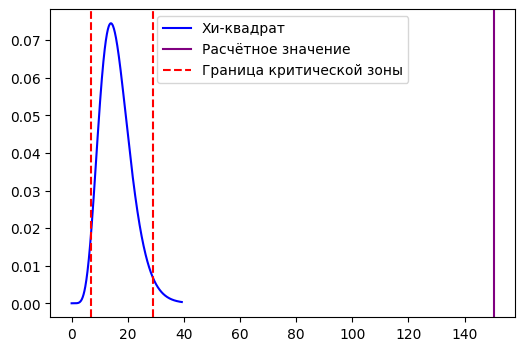

In [26]:
q1 = chi2.ppf(.025, df = degrfr)
q2 = chi2.ppf(.975, df = degrfr)
x = np.linspace(0, chi2.ppf(0.999, degrfr), 500)

fig, ax = plt.subplots(1,1)
ax.plot(x, chi2.pdf(x, degrfr), color = 'blue', label = 'Хи-квадрат')
ax.axvline(chi2_stat, color = 'purple', label = 'Расчётное значение')
ax.axvline(q1, color = 'red', linestyle = '--', label = 'Граница критической зоны')
ax.axvline(q2, color = 'red', linestyle = '--')
ax.legend()
plt.show()

**Вывод**

Обнаружена статистически значимая зависимость между признаками



In [32]:
stat_value = (chi2_stat/(n_all * min(K1,K2)-1))**.5

print(stat_value)

0.16262143920587646
